# Text Classification - Detect & Clean incorrect labels using cleanlab

## Outline
- Introduction
- Problem Description
- Background & related work
- Data Description
- Code
- Lessons Learnt

## Introduction 

WNUT-2020 Task 2: Identification of informative COVID-19 English Tweets. The goal of the task is to automatically identify whether an English Tweet related to the novel coronavirus (COVID-19) is informative or not. Such informative Tweets provide information about recovered, suspected, confirmed and death cases as well as location or travel history of the cases. Learn more from [here](http://noisy-text.github.io/2020/covid19tweet-task.html) 

In [ ]:
# make your Google Drive accessible
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive"
drive_data = f"{root_dir}/Colab Notebooks/covid"

Mounted at /content/gdrive


In [ ]:
%pip install fastai -Uq
%pip install nbdev -Uq
%pip install cleanlab -Uq



     |████████████████████████████████| 194kB 19.5MB/s 
     |████████████████████████████████| 12.8MB 199kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from pathlib import Path
from fastai.text.all import *
from fastcore.test import * 
#import fastai; fastai.utils.show_install()

In [ ]:
def replace_space(text, sep='_'):
  return sep.join(text.split(' '))

In [ ]:
def modify_metadata(column_value, tag_name):
  data = f"{tag_name}_{replace_space(column_value)}"
  data.replace(',', '')
  return data

In [ ]:
test_eq('aut_name_Jeremy_Howard', modify_metadata('Jeremy Howard', 'aut_name'))

In [ ]:
def clean_text(word):

  #Remove urls
  urls = re.findall(r'https?://\S+', word)
  if len(urls) > 0:
    word = ""
    return word
  
  return word.strip()

In [ ]:
Config.DEFAULT_CONFIG = {
        'data_path': f'{drive_data}',
        'data_archive_path': f'{drive_data}',
        'model_path': f'{drive_data}' + '/models'
    }

In [ ]:
Config.DEFAULT_CONFIG

{'data_archive_path': '/content/gdrive/My Drive/Colab Notebooks/covid',
 'data_path': '/content/gdrive/My Drive/Colab Notebooks/covid',
 'model_path': '/content/gdrive/My Drive/Colab Notebooks/covid/models'}

In [ ]:
bs=64

In [ ]:
covid_tweet = f"{drive_data}"; 
covid = Path(covid_tweet)

In [ ]:
Path.BASE_PATH = covid

In [ ]:
covid.ls()

(#5) [Path('train.tsv'),Path('valid.tsv'),Path('unlabeled_test_with_noise.tsv'),Path('test.tsv'),Path('README.md')]

## Preprocessing

In [ ]:
%pip install tweet-preprocessor

In [ ]:
#export
import re
def extract_hashtag(text):
  hash_tags = re.findall(r'#(\S+)', text)
  if hash_tags: 
    return ' '.join(hash_tags)
  else:
    return 'NA'

In [ ]:
import preprocessor as prep

In [ ]:
test_eq(['COVID-19'], extract_hashtag("welcome to the new world #COVID-19"))
test_eq(['COVID'], extract_hashtag("welcome to the new world #COVID"))
test_eq(['breakingnews', 'developing', 'covid19'], 
        extract_hashtag("welcome to the new world #breakingnews #developing #covid19"))

## Loading the data

In [ ]:
# Load all training, dev, test and private test set.
train_df = pd.read_csv(covid/'train.tsv', delimiter='\t')
valid_df = pd.read_csv(covid/'valid.tsv', names=['Id', 'Text', 'Label'], delimiter='\t')
test_df = pd.read_csv(covid/'test.tsv', names=['Id', 'Text', 'Label'], delimiter='\t')
private_test_df = pd.read_csv(covid/'unlabeled_test_with_noise.tsv', names=['Id', 'Text'], delimiter='\t')

In [ ]:
all_df = pd.concat([train_df, valid_df, test_df, private_test_df])

In [ ]:
len(train_df), len(valid_df), len(test_df), len(private_test_df)

(6936, 1000, 2000, 12000)

In [ ]:
stop_words = ['HTTPURL', '@USER']
all_df['Text'] =  all_df['Text'].apply(lambda x: ' '.join([each for each in x.split(' ') if each not in stop_words]))

In [ ]:
test_df['Text'] = test_df['Text'].apply(lambda x: ' '.join([each for each in x.split(' ') if each not in stop_words]))
test_df['HashTag'] = test_df.Text.apply(extract_hashtag)

In [ ]:
def remove_stop_add_hashtag(df):
  df['Text'] = df['Text'].apply(lambda x: ' '.join([each for each in x.split(' ') if each not in stop_words]))
  df['HashTag'] = df.Text.apply(extract_hashtag)
  return df

In [ ]:
train_df['is_valid'] = False
valid_df['is_valid'] = True

In [ ]:
train_val = pd.concat([train_df, valid_df])

In [ ]:
all_df['HashTag'] = all_df.Text.apply(extract_hashtag)

In [ ]:
train_val['HashTag'] = train_val.Text.apply(extract_hashtag)

In [ ]:
train_val.head()

,Id,Text,Label,is_valid,HashTag
0,1241490299215634434,Official death toll from #covid19 in the United Kingdom is now GREATER than: Germany + Poland + Switzerland + Austria + Portugal + Greece + Sweden + Finland + Norway + Ireland... COMBINED. UK: 67.5 Million (233 dead) Above group: 185 Million (230 dead) HTTPURL,INFORMATIVE,False,covid19
1,1245916400981381130,"Dearest Mr. President @USER 1,169 coronavirus deaths in the US in 24 hours (?) Covid19 pandemic is an international crime from China - not a nature disasster! Please use your authorities to protect your people and world against China! #ChinaHasToCompensateAll",INFORMATIVE,False,ChinaHasToCompensateAll
2,1241132432402849793,"Latest Updates March 20 ⚠️5274 new cases and 38 new deaths in the United States Illinois: Governo Pritzker issues ""stay at home"" order for all residents New York: Governor Cuomo orders 100% of all non-essential workers to stay home Penns...Source ( /coronavirus/country/us/ )",INFORMATIVE,False,NA
3,1236107253666607104,"真把公主不当干部 BREAKING: 21 people on Grand Princess cruise ship docked off the California coast tested positive for coronavirus, including 19 crew members and two passengers, Vice Pres. Mike Pence says. 24 people tested negative. HTTPURL HTTPURL",INFORMATIVE,False,NA
4,1239673817552879619,OKLAHOMA CITY — The State Department of Education announced Monday the closure of all K-12 public schools statewide until at least April 6 as the number of COVID-19 cases climb and the risk of community spread grows. HTTPURL,UNINFORMATIVE,False,NA


In [ ]:
len(train_df)

6936

In [ ]:
dls_lm = TextDataLoaders.from_df(all_df, seed=42, text_col=['HashTag', 'Text'], is_lm=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
lang_learn = language_model_learner(dls_lm, AWD_LSTM, metrics=Perplexity())

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.04786301031708717)

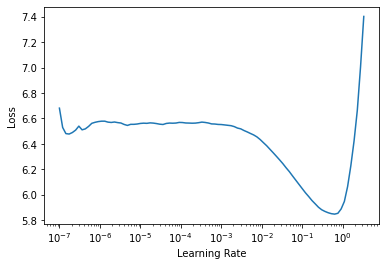

In [ ]:
lang_learn.lr_find()

In [ ]:
lang_learn.fine_tune(2, 4e-2)

epoch,train_loss,valid_loss,perplexity,time
0,4.171446,3.774947,43.595184,01:12


epoch,train_loss,valid_loss,perplexity,time
0,3.581508,3.392662,29.745029,01:23
1,3.233801,3.269958,26.310234,01:24


In [ ]:
lang_learn.save_encoder('fine_tuned_enc')

## Classifier

In [ ]:
db = DataBlock(blocks=(TextBlock.from_df(text_cols=['HashTag', 'Text'], is_lm=False, vocab=dls_lm.vocab), CategoryBlock),
               get_x=ColReader('text'),
               get_y=ColReader('Label'),
               splitter=ColSplitter(col='is_valid')
              )

In [ ]:
dls_cls = db.dataloaders(train_val, bs=64)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
learn = text_classifier_learner(dls_cls, arch=AWD_LSTM, metrics=[accuracy, F1Score(), Precision(), Recall()], loss_func=LabelSmoothingCrossEntropyFlat())

In [ ]:
learn.load_encoder('fine_tuned_enc')

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.0008317637839354575)

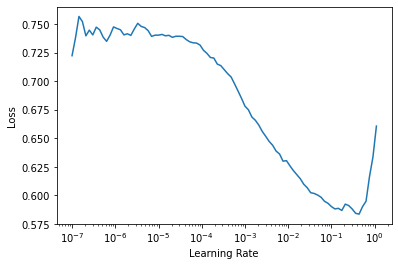

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 8e-4)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.511118,0.506876,0.788000,0.790099,0.827801,0.755682,00:12


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.453230,0.479938,0.800000,0.805068,0.829317,0.782197,00:20
1,0.432279,0.463301,0.821000,0.828380,0.838835,0.818182,00:21
2,0.414865,0.439383,0.838000,0.846008,0.849237,0.842803,00:21
3,0.389433,0.439651,0.838000,0.845124,0.853282,0.837121,00:21
4,0.368743,0.424290,0.853000,0.859330,0.868472,0.850379,00:21
5,0.352984,0.427471,0.851000,0.855199,0.878244,0.833333,00:21
6,0.341775,0.422503,0.852000,0.856867,0.875494,0.839015,00:21
7,0.326303,0.421930,0.851000,0.857416,0.866538,0.848485,00:21
8,0.326604,0.420502,0.852000,0.857418,0.872549,0.842803,00:21
9,0.319492,0.419501,0.852000,0.857692,0.871094,0.844697,00:21


In [ ]:
learn.export('basic.pkl')

## Inference

In [ ]:
def infer_predictions(learn, df, cols):
  tokenized_df = tokenize_df(df, text_cols=cols)
  test_dl = learn.dls.test_dl(tokenized_df[0])
  result = learn.get_preds(dl=test_dl, with_decoded=True)
  
  # Prediction, Confidence 
  _, y = learn.dls.valid.vocab
  y_predicted = np.array(y[predicted]);
  confidence = torch.max(result[0], axis=-1).values;

  return y_predicted, confidence

In [ ]:
tokenized_df = tokenize_df(test_df, text_cols=['Text', 'HashTag'])
test_dl = learn.dls.test_dl(tokenized_df[0], with_labels=True)
result = learn.get_preds(dl=test_dl, with_decoded=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
result[0].shape, result[1].shape, result[2].shape

(torch.Size([2000, 2]), torch.Size([2000]), torch.Size([2000]))

In [ ]:
confidence = torch.max(result[0], axis=-1).values;confidence

tensor([0.9495, 0.8612, 0.9765,  ..., 0.8892, 0.5078, 0.9341])

In [ ]:
  _, y = learn.dls.valid.vocab
  y_predicted = np.array(y[predicted]);y_predicted

array(['UNINFORMATIVE', 'UNINFORMATIVE', 'UNINFORMATIVE', ...,
       'INFORMATIVE', 'UNINFORMATIVE', 'INFORMATIVE'], dtype='<U13')

In [ ]:
test_df['confidence'] = confidence
test_df['predicted'] = y_predicted

In [ ]:
len(result), result[0].shape

(3, torch.Size([2000, 2]))

In [ ]:
[each.name for each in learn.metrics]

['accuracy', 'f1_score', 'precision_score', 'recall_score']

In [ ]:
learn.validate(ds_idx=1) # Validation Set got 85% accuracy and 0.857 f1 score

(#5) [0.4195009768009186,0.8519999980926514,0.8576923076923078,0.87109375,0.8446969696969697]

In [ ]:
learn.validate(dl=test_dl) # Room for improvement for test dataset

(#5) [0.49813932180404663,0.796500027179718,0.8229665071770335,0.7610619469026548,0.8958333333333334]

In [ ]:
result[0]

tensor([[0.0505, 0.9495],
        [0.1388, 0.8612],
        [0.0235, 0.9765],
        ...,
        [0.8892, 0.1108],
        [0.4922, 0.5078],
        [0.9341, 0.0659]])

In [ ]:
test_df.Label.values

array(['UNINFORMATIVE', 'INFORMATIVE', 'UNINFORMATIVE', ...,
       'INFORMATIVE', 'INFORMATIVE', 'INFORMATIVE'], dtype=object)

In [ ]:
Numericalize(vocab=['INFORMATIVE', 'UNINFORMATIVE'])(test_df.Label).numpy()

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
from cleanlab.pruning import get_noise_indices

In [ ]:
ordered_label_errors = get_noise_indices(s=Numericalize(vocab=['INFORMATIVE', 'UNINFORMATIVE'])(test_df.Label).numpy(), 
                                         psx=result[0].numpy(), 
                                         sorted_index_method='normalized_margin')

In [ ]:
len(ordered_label_errors) # We have identified around 194 problematic label errors in the test data itself.

194

In [ ]:
test_df.Label.value_counts()

UNINFORMATIVE    1056
INFORMATIVE       944
Name: Label, dtype: int64

In [ ]:
ordered_label_errors

array([1358, 1177,  398, 1694, 1501,  252, 1129,  852, 1353, 1174,   35,
        171, 1792,  242,  656, 1318, 1506, 1951, 1688, 1216,  522,  559,
       1978, 1937, 1064,  667,  376,  923,  440, 1108,   39, 1800, 1227,
        617,  156,  738,  290,  328,  636,  905,  768, 1558, 1355, 1971,
        130, 1392,  997,   27, 1235, 1657,   42,  570, 1677, 1156,  218,
       1740,  528,  211, 1825, 1898,   82, 1199, 1919, 1641, 1436, 1389,
        138, 1538,  225,    1, 1608, 1395, 1830, 1459, 1308,  129,  573,
       1224, 1217,  613, 1495, 1257, 1845, 1682,  316,  438, 1153,  904,
       1915,  827,  206,  117,  278,  870,  677, 1948, 1875, 1144, 1124,
        924,  652,  614, 1612,  878, 1077, 1255, 1734,  987, 1489, 1640,
       1851,   29, 1706,  775, 1375,  224,  286,  912,  421,  577, 1562,
       1904, 1098,  750, 1666,  773,  992,  392, 1135, 1559, 1555,  448,
       1471,  759,  977, 1137, 1415,  423,  196,  975, 1907, 1193, 1306,
        603,  329,  526,  524,  365,  877,   62,  1

In [ ]:
test_df['confidenceRange'] = pd.cut(test_df['confidence'], bins=[0.0, 0.6, 0.9, 1.0], labels=['<60', '60<90', '90+'],include_lowest=True)

In [ ]:
# Out of 194 samples, we can able to confirm 51 of them are with greater than 90% confidence being incorrect labeling
test_df.iloc[ordered_label_errors]['confidenceRange'].value_counts()

60<90    133
90+       51
<60       10
Name: confidenceRange, dtype: int64

## Storing the models in GDrive

In [ ]:
import shutil

In [ ]:
shutil.copy('./models/basic.pkl', drive_data + '/models')

'/content/gdrive/My Drive/Colab Notebooks/covid/models/basic.pkl'

In [ ]:
shutil.copy('./models/fine_tuned_enc.pth', drive_data + '/models')

'/content/gdrive/My Drive/Colab Notebooks/covid/models/fine_tuned_enc.pth'